# **Answers To Sales Data Analysis Project Business Questions**
We are going to answer the Business Questions required for this analysis and display the final report on Google slides.

## **Dataset Overview**
The dataset for this project includes the product names, ID, Date, Quantity, Price, Sales Volumes, and delivery Address of various products in various regions of United States of America in 2019.

### Importing Libraries and loading data

In [1]:
#importing libraries
import pandas as pd
import numpy as np
import seaborn as sns
import datetime
import matplotlib.pyplot as plt
from dotenv import dotenv_values
import pyodbc
from datetime import datetime
import plotly.express as px
import warnings
warnings.filterwarnings('ignore')

In [2]:
# load in the dataset into a pandas dataframe
df_2019 = pd.read_csv('data_2019.csv', index_col=False)
# Making a copy for the original dataset
df_2019_copy = df_2019.copy()

### **1. How much money did we make this year?**
To answer this question we need to create a `total amount` column from `Quantity_Ordered` multiplied by `Price_Each` then aggregate the yearly sales and filter out the 2019 sales, our year of focus.

In [3]:
df_2019 = df_2019.drop(df_2019.columns[0], axis=1)

In [4]:
#investigate 2019 dataset
df_2019.sample(5)

,Order_ID,Product,Quantity_Ordered,Price_Each,Order_Date,Purchase_Address,Product_level,City,Total_amount($)
34737,174599,Lightning Charging Cable,1,14.95,2019-03-10 16:45:00,"602 West St, Atlanta, GA 30301",basic level product,Atlanta,14.95
2568,143679,iPhone,1,700.00,2019-01-10 19:46:00,"292 Church St, Los Angeles, CA 90001",high-level product,San Francisco,700.00
78761,216812,Lightning Charging Cable,1,14.95,2019-06-03 21:28:00,"30 West St, Seattle, WA 98101",basic level product,Seattle,14.95
77610,215701,27in FHD Monitor,1,149.99,2019-06-17 07:33:00,"178 Dogwood St, Boston, MA 02215",high-level product,Boston,149.99
42771,182335,AA Batteries (4-pack),1,3.84,2019-04-08 09:14:00,"128 1st St, Atlanta, GA 30301",basic level product,Atlanta,3.84


In [5]:
#aggregate the Total-Amount sales to get the total sales for 2019
sales_2019 = df_2019['Total_amount($)'].sum()
f"Answer: This year(2019) we made ${sales_2019:,.2f} from product sales"

'Answer: This year(2019) we made $16,513,581.68 from product sales'

### **2. Can we identify any seasonality in the  sales?** 
To answer this question we will plot a monthly total sales graph to view the monthly sales variations throughout 2019 to establish whether there were any seasonal variations.

In [6]:
df_2019.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88473 entries, 0 to 88472
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Order_ID          88473 non-null  int64  
 1   Product           88473 non-null  object 
 2   Quantity_Ordered  88473 non-null  int64  
 3   Price_Each        88473 non-null  float64
 4   Order_Date        88473 non-null  object 
 5   Purchase_Address  88473 non-null  object 
 6   Product_level     88473 non-null  object 
 7   City              88473 non-null  object 
 8   Total_amount($)   88473 non-null  float64
dtypes: float64(2), int64(2), object(5)
memory usage: 6.1+ MB


In [7]:
#convert `Order_Date` data type to datetime
df_2019['Order_Date'] = df_2019['Order_Date'].astype('datetime64[ns]')
df_2019.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88473 entries, 0 to 88472
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Order_ID          88473 non-null  int64         
 1   Product           88473 non-null  object        
 2   Quantity_Ordered  88473 non-null  int64         
 3   Price_Each        88473 non-null  float64       
 4   Order_Date        88473 non-null  datetime64[ns]
 5   Purchase_Address  88473 non-null  object        
 6   Product_level     88473 non-null  object        
 7   City              88473 non-null  object        
 8   Total_amount($)   88473 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(2), object(4)
memory usage: 6.1+ MB


In [8]:
# Define plot size
plt.figure(figsize=(8, 6))

# Calculate monthly sales for all the 12 months of 2019
df_2019['Month'] = df_2019['Order_Date'].dt.month_name()
sale_2019_filtered = df_2019.groupby('Month')['Total_amount($)'].count().reset_index()

# Define the order of months
months_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

# Apply the categorical order to the 'Month' column
sale_2019_filtered['Month'] = pd.Categorical(sale_2019_filtered['Month'], categories=months_order, ordered=True)

# Sort by the categorical order
sale_2019_filtered = sale_2019_filtered.sort_values(by='Month')

sale_2019_filtered

,Month,Total_amount($)
4,January,9665
3,February,11956
7,March,15127
0,April,18256
8,May,16551
6,June,13534
5,July,467
1,August,411
11,September,404
10,October,675


<Figure size 800x600 with 0 Axes>

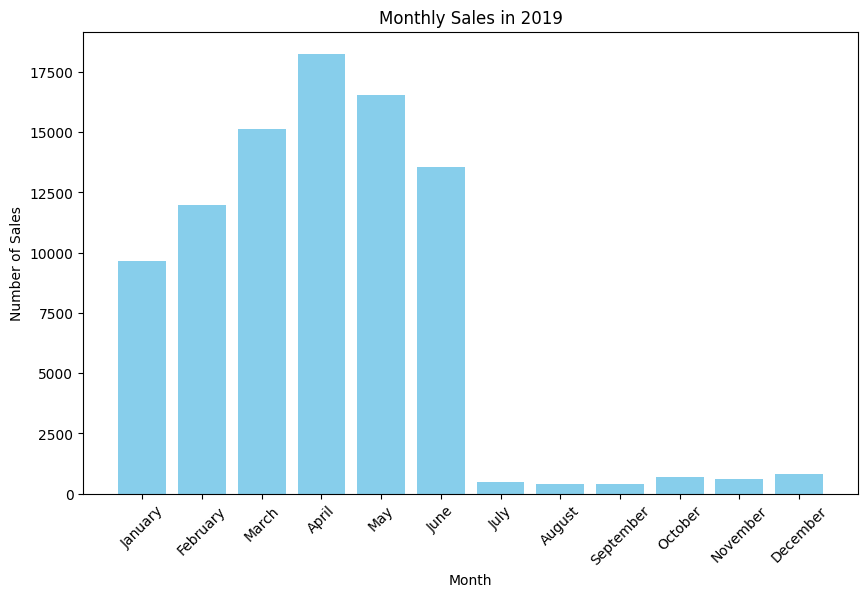

In [9]:
# Define plot size
plt.figure(figsize=(10, 6))

# Plot the bar chart
plt.bar(sale_2019_filtered['Month'], sale_2019_filtered['Total_amount($)'], color='skyblue')

# Add title and labels
plt.title('Monthly Sales in 2019')
plt.xlabel('Month')
plt.ylabel('Number of Sales')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Display the plot
plt.show()

##### **Answer**
* There tends to be more sales in the first half of the year 2019, with the higest amount of sales being 3.4 million. The sales tend to drop in the 7th month of the year, with the lowest amount of sales being 1.1 million.

### **3. What are our best and worst-selling products?**
To answer this question we will aggregate the quantities of each product sold and arrange them in descending order. We can generate a bar chart to visualize the information.

In [10]:
products = df_2019.groupby('Product')['Quantity_Ordered'].sum().reset_index()

perfomance = products.sort_values(by='Quantity_Ordered',ascending=False).reset_index()

perfomance

,index,Product,Quantity_Ordered
0,5,AAA Batteries (4-pack),14697
1,4,AA Batteries (4-pack),13210
2,15,USB-C Charging Cable,11311
3,12,Lightning Charging Cable,11060
4,17,Wired Headphones,9817
5,6,Apple Airpods Headphones,7448
6,7,Bose SoundSport Headphones,6377
7,2,27in FHD Monitor,3640
8,18,iPhone,3331
9,3,34in Ultrawide Monitor,2998


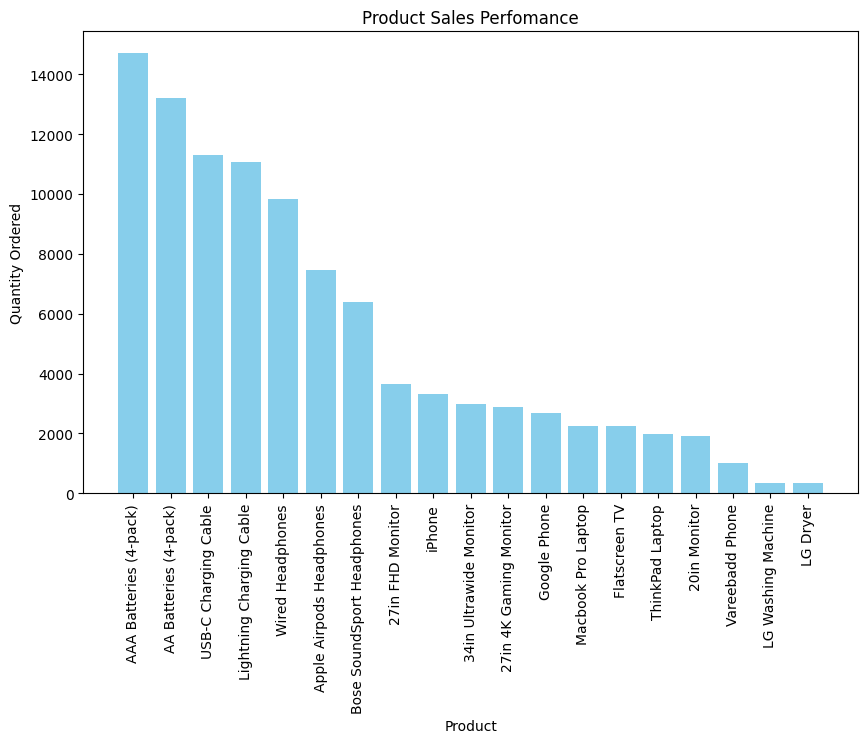

In [11]:
# Define plot size
plt.figure(figsize=(10, 6))

# Plot the bar chart
plt.bar(perfomance['Product'], perfomance['Quantity_Ordered'], color='skyblue')

# Add title and labels
plt.title('Product Sales Perfomance')
plt.xlabel('Product')
plt.ylabel('Quantity Ordered')

# Rotate x-axis labels for better readability
plt.xticks(rotation=90)

# Display the plot
plt.show()

##### **Answer**
* From the figure above the Best selling products is `AAA Batteries(4-pack)` with a total order of 14,697, while the worst selling products is the `LG Dryer` with a total order of 331 sales.

### **4. How do sales compare to previous months or weeks?**
To answer this question we will aggregate monthly sales throughout the year for monthly comparision and do a weekly aggregate for weekly comparision, we will as well graph a pair plot for the weekly, monthly and total sales variables to see the bivariate distribution of those sales.

In [12]:
#aggregate the weekly, monthly and totol sales 
df_2019['Month'] = df_2019['Order_Date'].dt.month

df_2019['Week'] = df_2019['Order_Date'].dt.isocalendar().week

df_2019.head(3)

sales_monthly_weekly = df_2019.groupby(['Month','Week'])['Total_amount($)'].sum()

sales_monthly_weekly


Month  Week
1      1       344678.730000
       2       409389.430000
       3       394921.110000
       4       426020.170000
       5       237733.430000
2      5       221837.190000
       6       565300.050000
       7       568196.290000
       8       535207.510000
       9       309534.050000
3      9       268772.390000
       10      640496.380000
       11      595771.070000
       12      629060.550000
       13      670861.010000
4      14      774492.970000
       15      761454.220000
       16      805297.450000
       17      808682.730000
       18      239278.660000
5      18      525183.960000
       19      729309.990000
       20      695631.880000
       21      709784.550000
       22      490555.850000
6      22      177534.310000
       23      616368.480000
       24      594043.830000
       25      611459.510000
       26      576724.030000
7      27        3028.380000
       29       73736.119558
8      34       73121.099612
9      38       63822.469717
10

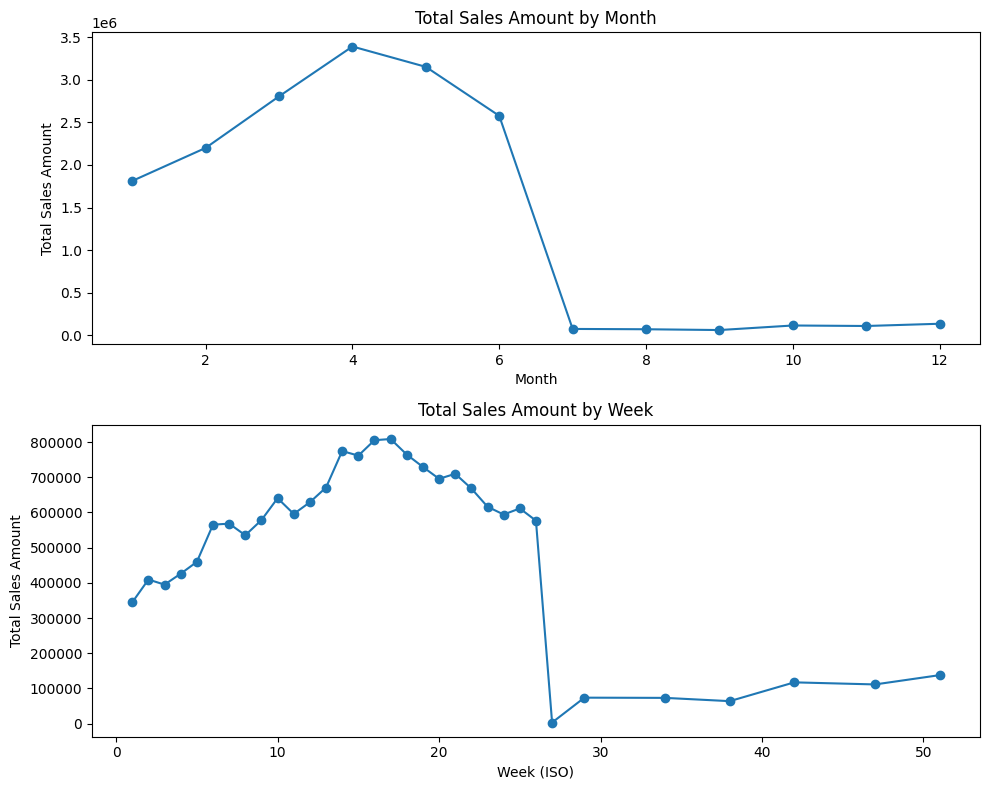

In [13]:
# Line plot for Monthly Sales

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# Line plot for Monthly Sales
monthly_sales = df_2019.groupby('Month')['Total_amount($)'].sum()
ax1.plot(monthly_sales.index, monthly_sales.values, marker='o', linestyle='-')
ax1.set_xlabel('Month')
ax1.set_ylabel('Total Sales Amount')
ax1.set_title('Total Sales Amount by Month')
ax1.tick_params(axis='x', rotation=0)
ax1.grid(False)

# Line plot for Weekly Sales
weekly_sales = df_2019.groupby('Week')['Total_amount($)'].sum()
ax2.plot(weekly_sales.index, weekly_sales.values, marker='o', linestyle='-')
ax2.set_xlabel('Week (ISO)')
ax2.set_ylabel('Total Sales Amount')
ax2.set_title('Total Sales Amount by Week')  # Corrected here
ax2.tick_params(axis='x', rotation=0)
ax2.grid(False)

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

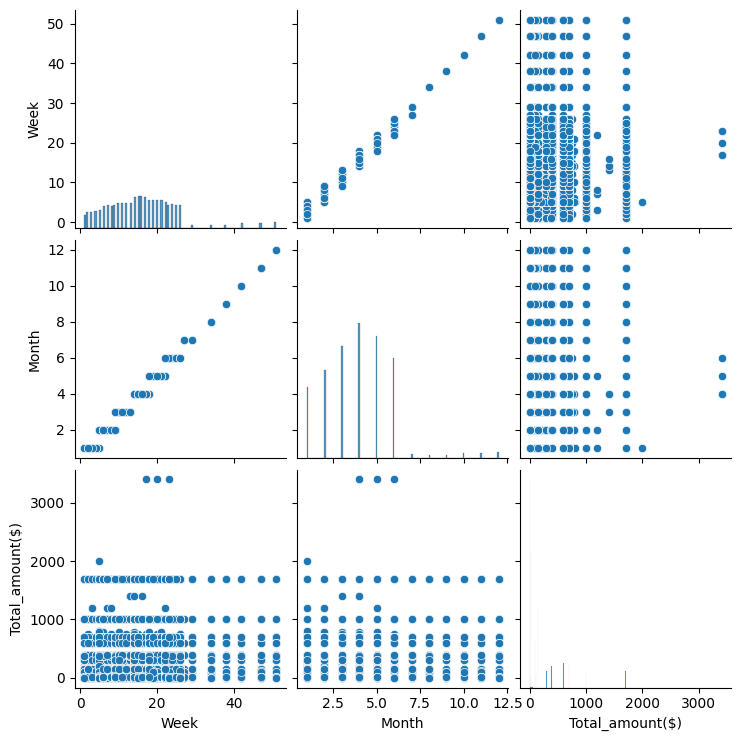

In [14]:
#pairplot distribution analysis
sns.pairplot(df_2019[['Week', 'Month', 'Total_amount($)']])
plt.grid(False)
plt.show()

##### **Answer**
* According to the analysis of the data throughout the year 2019, the sales are high in the first half months of the year but they drop in the second half.
* When data is analysed weekly, there are flactuations in sales such that sometimes an increase is observed but, then followed by a slight dip in sales. This trend goes on for the first half of the year till week 26 where the trend takes a deep drop in sales then maintains lower sells volumes with slight changes through the rest of the year.

### **5. Which cities are our products delivered to most?**
To answer this question we will aggregate the quantities ordered by the `City` variable and arrage them in descending order. We will plot a bar graph to illustrate that

In [15]:
#filter te 2019 dataset
df_2019 = df_2019[df_2019['Order_Date'].dt.year == 2019]

#aggregate sales by `City` and arrange them in descending order
city_delivery = df_2019.groupby('City')['Quantity_Ordered'].count()
city_delivery = city_delivery.sort_values(ascending=False)  # Sort the city_delivery Series
city_delivery

City
San Francisco    35454
New York         11805
Dallas           11757
Boston            9389
Atlanta           7167
Seattle           6883
Portland          6018
Name: Quantity_Ordered, dtype: int64

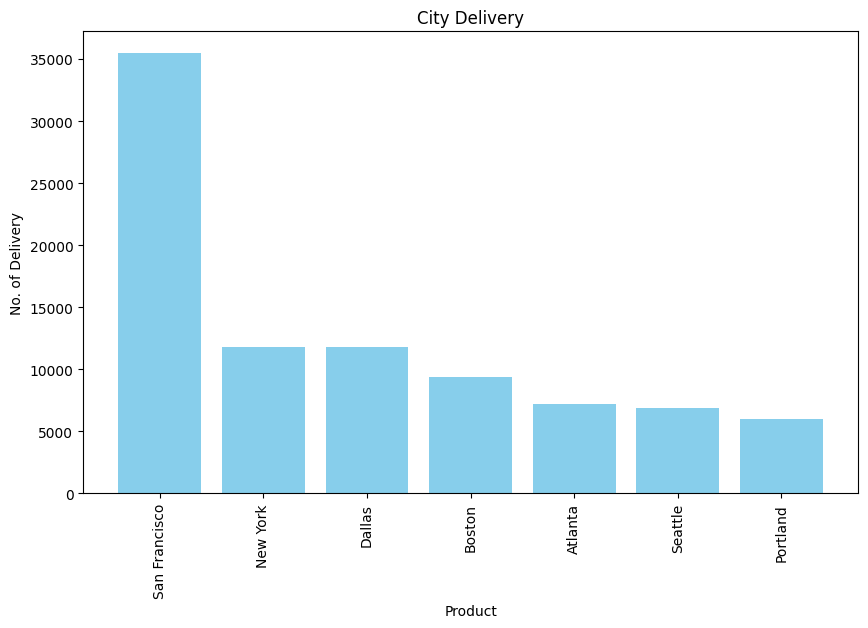

In [16]:
# Define plot size
plt.figure(figsize=(10, 6))

# Plot the bar chart
plt.bar(city_delivery.index, city_delivery.values, color='skyblue')

# Add title and labels
plt.title('City Delivery')
plt.xlabel('Product')
plt.ylabel('No. of Delivery')

# Rotate x-axis labels for better readability
plt.xticks(rotation=90)

# Display the plot
plt.show()

##### **Answer**
* The City of `San Francisco` has the highest number of deliveries with a total of 35,454 deliveries whereas the City with the lowest number of deliveries is `Portland` with a total of 6,018 deliveries done in year 2019.

###  **6. How do product categories compare in revenue generated and quantities  ordered?**
We will aggregate product revenues and sales voules and compare them side by side on a table and a graph to illustrate the differences.

In [17]:
#aggregate product revenues and sales volumes
product_category = df_2019.groupby('Product').agg({'Quantity_Ordered': 'sum', 'Total_amount($)': 'sum'}).reset_index()

product_category  = product_category.sort_values(by='Total_amount($)', ascending=False)
product_category

,Product,Quantity_Ordered,Total_amount($)
13,Macbook Pro Laptop,2242,3.811400e+06
18,iPhone,3331,2.331700e+06
14,ThinkPad Laptop,1983,1.982980e+06
9,Google Phone,2695,1.617000e+06
3,34in Ultrawide Monitor,2998,1.139210e+06
1,27in 4K Gaming Monitor,2890,1.127071e+06
6,Apple Airpods Headphones,7448,1.117200e+06
8,Flatscreen TV,2233,6.699000e+05
7,Bose SoundSport Headphones,6377,6.376362e+05
2,27in FHD Monitor,3640,5.459636e+05


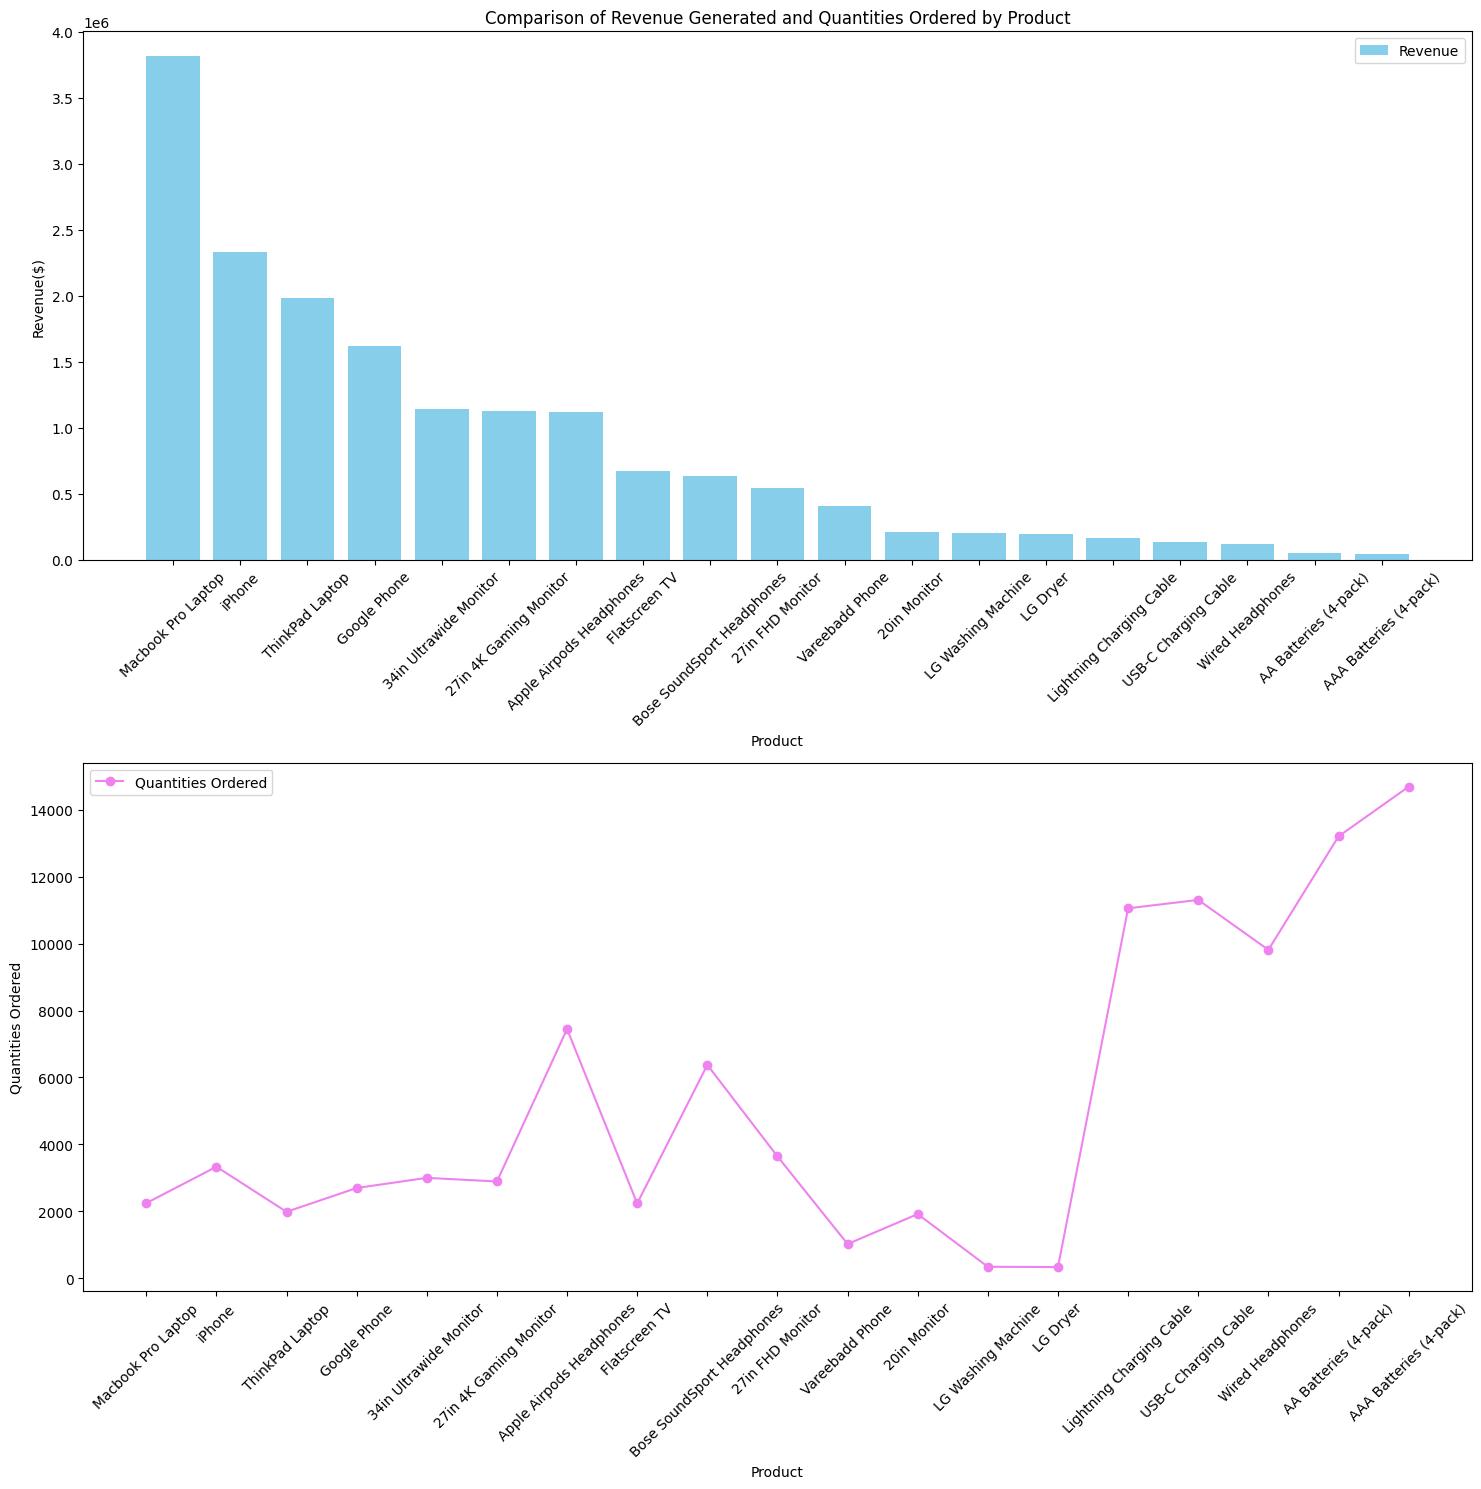

In [18]:
#figure and axes for subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 15))

# Bar plot for revenue
ax1.bar(product_category['Product'], product_category['Total_amount($)'], label='Revenue', color='skyblue')

# Set labels and title for the first subplot
ax1.set_xlabel('Product')
ax1.set_ylabel('Revenue($)')
ax1.set_title('Comparison of Revenue Generated and Quantities Ordered by Product')
ax1.tick_params(axis='x', rotation=45)  # Rotate x-axis labels for better readability
ax1.legend()
ax1.grid(False)

# Line plot for quantities ordered
ax2.plot(product_category['Product'], product_category['Quantity_Ordered'], marker='o', color='violet', label='Quantities Ordered')

# Set labels and title for the second subplot
ax2.set_xlabel('Product')
ax2.set_ylabel('Quantities Ordered')
ax2.tick_params(axis='x', rotation=45)  # Rotate x-axis labels for better readability
ax2.legend()
ax2.grid(False)

# Adjust layout
plt.tight_layout()

##### **Answer**
* The top 5 products with the highest order number shows that they are the ones with the least revenue generation and some products with the lowest order number indicates a better revenue generation.

### **7. Between the two levels which is the dominant product level?**
Aggregate the product count by the product level variable and plot pie chart to see the share of each category.

In [19]:
# Grouping by 'Product_level' and counting the occurrences

product_group = df_2019.groupby('Product_level').size().reset_index(name='Count')

product_group

,Product_level,Count
0,basic level product,49450
1,high-level product,39023


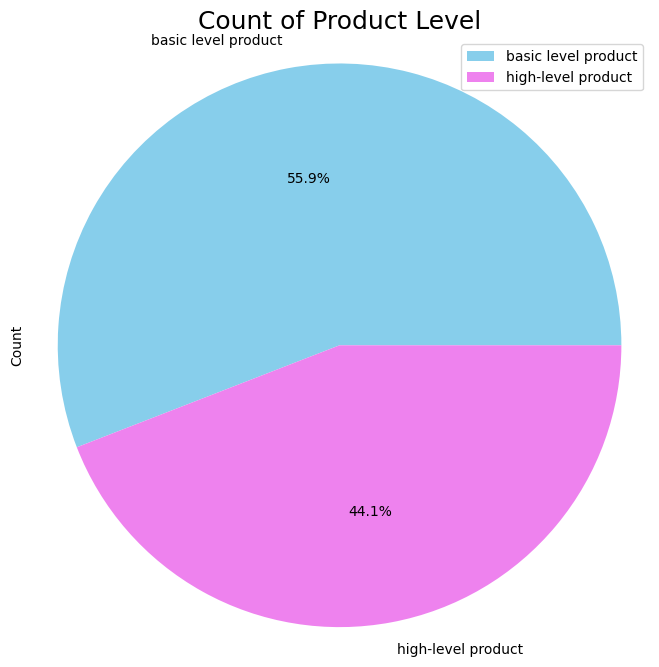

In [20]:
#plot piechart
colors = ['skyblue', 'violet']

# Create the pie chart
ax = product_group.plot(kind='pie', y='Count', labels=product_group['Product_level'], colors=colors, labeldistance=1.1, autopct='%1.1f%%', figsize=(8, 8))
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Count of Product Level', fontsize=18)
plt.legend(loc='upper right')  # Show legend
plt.show()

##### **Answer**
* The `basic level products` dominate the `high-level products` with a `55.9%`share of product relative to a `44.1%` share.

# **Thank You**

In [21]:
# The command below will generate the HTML slideshow. 
!jupyter nbconvert answers.ipynb --to slides --post serve --no-input --no-prompt 

^C


: 